In [213]:
from pymorphy2 import MorphAnalyzer
import pandas as pd
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import sklearn
import os

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost import cv
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from catboost.utils import create_cd
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
from catboost.utils import get_roc_curve
from sklearn import metrics
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [214]:
# Создаем экземпляр MorphAnalyzer
morph = MorphAnalyzer()

def preprocess_text(text):
    # Разделяем текст на слова, нормализуем каждое слово и возвращаем множество нормализованных форм
    return set(morph.parse(word)[0].normal_form for word in text.split())

# Считывание данных из Excel-файла
id = pd.read_excel('id.xlsx')

# Создание нового столбца с нормализованными формами слов в столбце "Название"
id['normalized_names'] = id['Название'].apply(preprocess_text)

# Показываем первые строки для проверки
print(id.head())


   id                                           Название  Нормализованный  \
0   1  Административное здание, 676014, Амурская обла...              NaN   
1   2  Гараж, 676450, Амурская область, г.Свободный, ...              NaN   
2   3  Гараж, 676014, Амурская область, г.Сковородино...              NaN   
3   4  Служебное здание, 676450, Амурская область, г....              NaN   
4   5  Убежище служебного здания, 676450, Амурская об...              NaN   

                                    normalized_names  
0  {амурский, г.сковородино,, победа, 04-01-06-00...  
1  {г.свободный,, дзержинский, амурский, д.49,, 0...  
2  {04-05-06-00-00-037, амурский, г.сковородино,,...  
3  {г.свободный,, дзержинский, амурский, служебны...  
4  {г.свободный,, дзержинский, амурский, здания,,...  


In [215]:
payment = pd.read_excel('Платежи.xlsx')

# Создание нового столбца с нормализованными формами слов в столбце "Название"
payment['normalized_names'] = payment['Направление расходов'].apply(preprocess_text)

# Показываем первые строки для проверки
print(payment.head())

                                    Подразделение БР  \
0  Дальневосточное главное управление Центральног...   
1  Дальневосточное главное управление Центральног...   
2  Дальневосточное главное управление Центральног...   
3  Дальневосточное главное управление Центральног...   
4  Дальневосточное главное управление Центральног...   

          Наименование вида расходов  \
0  Оплата потребления электроэнергии   
1  Оплата потребления электроэнергии   
2  Оплата потребления электроэнергии   
3  Оплата потребления электроэнергии   
4  Оплата потребления электроэнергии   

                                Направление расходов  Конечный остаток  \
0  Расходы прошлого года. Оплата потребления элек...           9498.58   
1  Расходы прошлого года. Оплата потребления элек...          16294.01   
2  Оплата потребления электроэнергии ул.Светланск...          32149.60   
3  Оплата потребления электроэнергии ул.Светланск...          36805.90   
4  Оплата потребления электроэнергии ул.Светланск...

In [224]:

# Функция для расчета коэффициента Жаккара между двумя множествами
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Предполагаем, что у нас есть два DataFrame: payment и id_df
# и в каждом есть столбец 'normalized_names'

# Добавляем столбец для id в payment DataFrame
payment['matched_id'] = None

# Итерируем по каждой строке в payment с помощью tqdm
for i, payment_row in tqdm(payment.iterrows(), total=payment.shape[0]):
    best_match_ratio = 0
    best_match_id = None
    
    # Итерируем по каждой строке в id_df
    for j, id_row in id.iterrows():
        # Считаем коэффициент Жаккара
        ratio = jaccard_similarity(payment_row['normalized_names'], id_row['normalized_names'])
        
        # Если текущий коэффициент лучше предыдущего, обновляем best_match_id
        if ratio > best_match_ratio:
            best_match_ratio = ratio
            best_match_id = id_row['id']
    
    # Записываем найденный id в столбец 'matched_id'
    payment.at[i, 'matched_id'] = best_match_id


  0%|          | 0/23150 [00:00<?, ?it/s]

100%|██████████| 23150/23150 [10:37<00:00, 36.33it/s]


In [45]:
# payment.to_excel('payment.xlsx')

In [4]:
#объединим все данные по объектам недвижимости


# Установите путь к родительской папке
# parent_folder_path = 'train_data/Lists ON'

# # Список для всех DataFrame
# all_dataframes = []

# # Проходимся по всем подпапкам и файлам в родительской папке
# for subdir, dirs, files in os.walk(parent_folder_path):
#     for file in files:
#         # Проверяем, является ли файл файлом Excel
#         if file.endswith('.xlsx') or file.endswith('.xls'):
#             # Считываем файл Excel в DataFrame
#             file_path = os.path.join(subdir, file)
#             df = pd.read_excel(file_path)
#             # Добавляем DataFrame в список
#             all_dataframes.append(df)

# # Объединяем все DataFrame в один большой DataFrame
# combined_df = pd.concat(all_dataframes, ignore_index=True)

# Теперь у вас есть один DataFrame с данными из всех файлов
# combined_df.to_excel('combined_df.xlsx')


In [225]:
combined_df = pd.read_excel('combined_df.xlsx')

In [226]:
# Объединение DataFrame id и combined_df по столбцу "Название"
merged_df = pd.merge(id, combined_df, on="Название", how="left")

In [227]:
remont = pd.read_excel('remont.xlsx')

In [228]:
# Объединение DataFrame id и combined_df по столбцу "Название"
merged_df = pd.merge(merged_df, remont, on="Название", how="left")

In [229]:
merged_df.to_excel('merged_df.xlsx')

In [231]:
# Объединение DataFrame payment и merged_df
# Важно, что мы используем 'left' join, чтобы сохранить все строки из payment
payment_updated = pd.merge(payment, merged_df, left_on="matched_id", right_on="id", how="left")

# В результате payment_updated содержит все столбцы из payment и добавленные столбцы из merged_df


In [232]:
payment_updated.to_excel('payment_updated.xlsx')

In [233]:
payment_updated = pd.read_excel('payment_updated.xlsx')
# Удаление записей, где 'Техническое состояние' пусто
payment_updated = payment_updated.dropna(subset=['Техническое состояние'])



In [235]:
# Преобразование столбца 'Дата проведения' в datetime
payment_updated['Дата проведения'] = pd.to_datetime(payment_updated['Дата проведения'], format='%d.%m.%Y')

# Создание столбцов 'month' и 'year'
payment_updated['month'] = payment_updated['Дата проведения'].dt.month
payment_updated['year'] = payment_updated['Дата проведения'].dt.year

# Переименовываем столбец 'Конечный остаток' в 'payment'
payment_updated = payment_updated.rename(columns={'Конечный остаток': 'payment'})

# Проверяем результат
print(payment_updated[['Дата проведения', 'month', 'year']].head())


   Дата проведения  month  year
1       2016-02-10      2  2016
14      2016-02-24      2  2016
15      2016-03-23      3  2016
16      2016-04-21      4  2016
17      2016-05-20      5  2016


In [259]:
# Удаление пробелов в начале и в конце названий городов
payment_updated['Город'] = payment_updated['Город'].apply(lambda x: x.strip())

payment_updated['Город'] = payment_updated['Город'].replace('Ключи', 'Горные ключи')


# Создание словаря с городами
cities_dict = {
    "Анадырь": 1,
    "Билибино": 2,
    "Якутск": 3,
    "Ленск": 4,
    "Нерюнгри": 5,
    "Усть-Нера": 6,
    "Усть-Омчуг": 7,
    "Эгвекинот": 8,
    "Магадан": 9,
    "Провидения": 10,
    "Лаврентия": 11,
    "Вилючинск": 12,
    "Петропавловск-Камчатский": 13,
    "Усть-Камчатск": 14,
    "Тиличики": 15,
    "Паратунка": 16,
    "Курильск": 17,
    "Горные Ключи": 18,
    "Спасск-Дальний": 19,
    "Дальнереченск": 20,
    "Славянка": 21,
    "Владивосток": 22,
    "Уссурийск": 23,
    "Находка": 24,
    "Партизанск": 25,
    "Вольно-Надеждинское": 26,
    "Горные ключи": 27,
    "Александровск-Сахалинский": 28,
    "Южно-Сахалинск": 29,
    "Сковородино": 30,
    "Тында": 31,
    "Благовещенск": 32,
    "Свободный": 33,
    "Биробиджан": 34,
    "Покровск": 35,
    "Комсомольск-на-Амуре": 36,
    "Чурапча": 37,
    "Хабаровск": 38  # Добавлен в список
}

payment_updated['Климат'] = payment_updated['Город'].map(cities_dict)

# Проверяем результат
print(payment_updated[['Город', 'Климат']].head())



        Город  Климат
1     Анадырь       1
14  Хабаровск      38
15  Хабаровск      38
16  Хабаровск      38
17  Хабаровск      38


In [261]:
# Отфильтровываем строки, где 'Климат' является NaN
nan_climate = payment_updated[payment_updated['Климат'].isna()]

# Показываем строки, где 'Климат' является NaN
print(nan_climate[['Город', 'Климат']])


Empty DataFrame
Columns: [Город, Климат]
Index: []


In [262]:
# Определяем виды расходов для удаления
expenses_to_remove = [
    'Расходы на коммунальные услуги',
    'Расходы на коммунальные услуги (расходы прошлых лет)',
    'Коммунальные услуги (расходы прошлых лет)'
]

# Удаляем строки, где 'Наименование вида расходов' содержит один из этих видов расходов
payment_updated = payment_updated[~payment_updated['Наименование вида расходов'].isin(expenses_to_remove)]



In [263]:
# Инициализация новых столбцов
payment_updated['payment_el'] = 0
payment_updated['payment_teplo'] = 0
payment_updated['payment_gaz'] = 0
payment_updated['payment_voda'] = 0

# Определение видов расходов для каждой категории
electricity_expenses = ['Оплата потребления электроэнергии', 'Расходы по оплате потребления электроэнергии']
heating_expenses = [
    'Оплата потребления тепловой энергии',
    'Расходы по оплате всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)',
    'Оплата всех видов отопления зданий и сооружений (кроме электро- и газового снабжения)'
]
gas_expenses = ['Расходы по оплате потребления газа', 'Оплата потребления газа']
water_expenses = [
    'Оплата водоснабжения, канализации',
    'Расходы по оплате услуг водоснабжения, водоотведения',
    'Оплата услуг водоснабжения, водоотведения'
]

# Заполнение новых столбцов
payment_updated.loc[payment_updated['Наименование вида расходов'].isin(electricity_expenses), 'payment_el'] = payment_updated['payment']
payment_updated.loc[payment_updated['Наименование вида расходов'].isin(heating_expenses), 'payment_teplo'] = payment_updated['payment']
payment_updated.loc[payment_updated['Наименование вида расходов'].isin(gas_expenses), 'payment_gaz'] = payment_updated['payment']
payment_updated.loc[payment_updated['Наименование вида расходов'].isin(water_expenses), 'payment_voda'] = payment_updated['payment']

# Проверяем результат
# print(payment_updated.head())



In [264]:
# Преобразование столбца 'Дата' в economic в datetime (если это еще не сделано)
economic = pd.read_excel('economic.xlsx')
economic['Дата'] = pd.to_datetime(economic['Дата'])

# Создание столбцов 'month' и 'year' в economic
economic['month'] = economic['Дата'].dt.month
economic['year'] = economic['Дата'].dt.year

# Объединение payment_updated и economic
payment_updated_with_economic = pd.merge(payment_updated, economic, on=['month', 'year'], how='left')

# Проверяем результат
print(payment_updated_with_economic.head())


   Unnamed: 0                                   Подразделение БР  \
0           1  Дальневосточное главное управление Центральног...   
1          14  Дальневосточное главное управление Центральног...   
2          15  Дальневосточное главное управление Центральног...   
3          16  Дальневосточное главное управление Центральног...   
4          17  Дальневосточное главное управление Центральног...   

          Наименование вида расходов  \
0  Оплата потребления электроэнергии   
1  Оплата потребления электроэнергии   
2  Оплата потребления электроэнергии   
3  Оплата потребления электроэнергии   
4  Оплата потребления электроэнергии   

                                Направление расходов   payment  \
0  Расходы прошлого года. Оплата потребления элек...  16294.01   
1  Оплата потребления электроэнергии ул. Калинина...  21330.22   
2  Оплата потребления электроэнергии ул. Калинина...  24348.71   
3  Оплата потребления электроэнергии ул. Калинина...  21696.45   
4  Оплата потреблени

In [265]:
payment_updated_with_economic.to_excel('payment_updated_with_economic.xlsx')

In [266]:
payment_updated = payment_updated_with_economic

In [289]:
# Переименование столбца
payment_updated = payment_updated.rename(columns={"Энергоэффективный(2)/Не энергоэффективный(0)/Нейтральный(1)\\": "Энергоэффективность"})
# Преобразование всех значений в 'Год постройки' в числа, нечисловые значения станут NaN
payment_updated['Год постройки'] = pd.to_numeric(payment_updated['Год постройки'], errors='coerce')

# Вычисление среднего значения для числовых данных
mean_year = payment_updated['Год постройки'].mean()

# Замена NaN на среднее значение
payment_updated['Год постройки'].fillna(mean_year, inplace=True)

# Словарь для замены текстовых значений на числовые
replace_values = {
    'Хорошее': 4,
    'Удовлетворительное': 3,
    'Ветхое': 2,
    'Аварийное': 1
}

# Замена значений в столбце 'Техническое состояние'
payment_updated['Техническое состояние'] = payment_updated['Техническое состояние'].replace(replace_values)

# Проверяем результат
print(payment_updated['Техническое состояние'].head())




0    3
1    3
2    3
3    3
4    3
Name: Техническое состояние, dtype: int64


In [290]:
# Создаем отдельные DataFrame для каждого вида расходов
df_payment_el = payment_updated[payment_updated['payment_el'] != 0]
df_payment_teplo = payment_updated[payment_updated['payment_teplo'] != 0]
df_payment_gaz = payment_updated[payment_updated['payment_gaz'] != 0]
df_payment_voda = payment_updated[payment_updated['payment_voda'] != 0]

# Удаление ненужных столбцов из df_payment_el
df_payment_el = df_payment_el.drop(columns=['payment', 'payment_teplo', 'payment_gaz', 'payment_voda', 'normalized_names_x', 'Нормализованный', 'normalized_names_y','Энергоэффективность',])

# Удаление ненужных столбцов из df_payment_teplo
df_payment_teplo = df_payment_teplo.drop(columns=['payment', 'payment_el', 'payment_gaz', 'payment_voda', 'normalized_names_x', 'Нормализованный', 'normalized_names_y','Энергоэффективность',])

# Удаление ненужных столбцов из df_payment_gaz
df_payment_gaz = df_payment_gaz.drop(columns=['payment', 'payment_el', 'payment_teplo', 'payment_voda', 'normalized_names_x', 'Нормализованный', 'normalized_names_y','Энергоэффективность',])

# Удаление ненужных столбцов из df_payment_voda
df_payment_voda = df_payment_voda.drop(columns=['payment', 'payment_el', 'payment_teplo', 'payment_gaz', 'normalized_names_x', 'Нормализованный', 'normalized_names_y','Энергоэффективность',])


# Переименовываем столбец в df_payment_el
df_payment_el = df_payment_el.rename(columns={'payment_el': 'payment'})

# Переименовываем столбец в df_payment_teplo
df_payment_teplo = df_payment_teplo.rename(columns={'payment_teplo': 'payment'})

# Переименовываем столбец в df_payment_gaz
df_payment_gaz = df_payment_gaz.rename(columns={'payment_gaz': 'payment'})

# Переименовываем столбец в df_payment_voda
df_payment_voda = df_payment_voda.rename(columns={'payment_voda': 'payment'})

# Проверяем результат
# print("Электроэнергия:", df_payment_el.head())
# print("Теплоэнергия:", df_payment_teplo.head())
# print("Газ:", df_payment_gaz.head())
# print("Вода:", df_payment_voda.head())




In [287]:
def diagnostics(y, y_pred):
    residuals = y - y_pred
    residuals_mean = np.round(np.mean(y - y_pred), 3)
 
    f, ((ax_rkde, ax_prob), (ax_yy, ax_ykde)) = plt.subplots(nrows = 2,
                                                                             ncols = 2,
                                                                             figsize = (12, 12))
 
  # в первом подграфике построим график плотности
    sns.kdeplot(residuals, fill = True, ax = ax_rkde)
    ax_rkde.set_title('Residuals distribution', fontsize = 14)
    ax_rkde.set(xlabel = f'Residuals, mean: {residuals_mean}')
    ax_rkde.set(ylabel = 'Density')
 
  # во втором график нормальной вероятности остатков
    probplot(residuals, dist = 'norm', plot = ax_prob)
    ax_prob.set_title('Residuals probability plot', fontsize = 14)
 

 
    # на четвертом сравним прогнозные и фактические значения
    ax_yy.scatter(y, y_pred)
    ax_yy.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw = 1)
    ax_yy.set_title('Actual vs. Predicted', fontsize = 14)
    ax_yy.set(xlabel = 'y_true')
    ax_yy.set(ylabel = 'y_pred')
 
    sns.kdeplot(y, fill = True, ax = ax_ykde, label = 'y_true')
    sns.kdeplot(y_pred, fill = True, ax = ax_ykde, label = 'y_pred')
    ax_ykde.set_title('Actual vs. Predicted Distribution', fontsize = 14)
    ax_ykde.set(xlabel = 'y_true and y_pred')
    ax_ykde.set(ylabel = 'Density')
    ax_ykde.legend(loc = 'upper right', prop = {'size': 12})
 
    plt.tight_layout()
 
    plt.show()

In [292]:
cat_features = ['Город',]

Learning rate set to 0.05163
0:	learn: 267070.7692026	total: 158ms	remaining: 2m 37s
100:	learn: 228113.2461627	total: 3.79s	remaining: 33.7s
200:	learn: 218588.8135760	total: 7.24s	remaining: 28.8s
300:	learn: 209876.6045327	total: 10.4s	remaining: 24.1s
400:	learn: 204186.2989586	total: 13.7s	remaining: 20.4s
500:	learn: 199880.3827311	total: 16.8s	remaining: 16.8s
600:	learn: 195066.7901579	total: 20.2s	remaining: 13.4s
700:	learn: 191668.1819657	total: 23.9s	remaining: 10.2s
800:	learn: 188859.9401627	total: 27.3s	remaining: 6.78s
900:	learn: 186629.9859089	total: 30.9s	remaining: 3.4s
999:	learn: 184584.1447645	total: 34.7s	remaining: 0us
Среднеквадратическая ошибка: 68305941677.386635


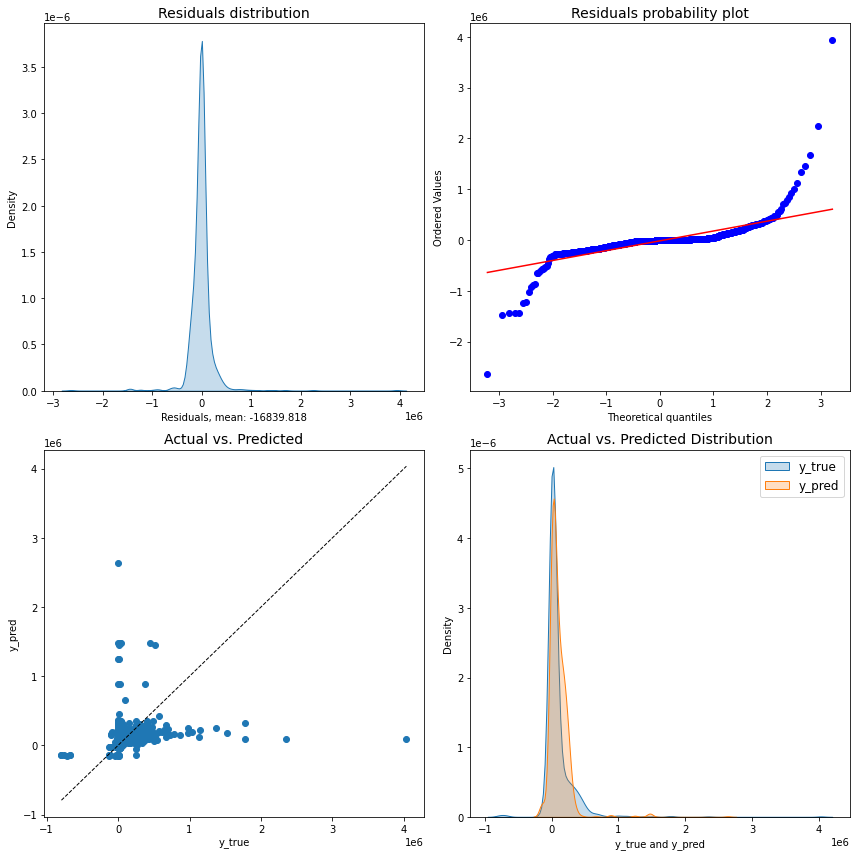

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


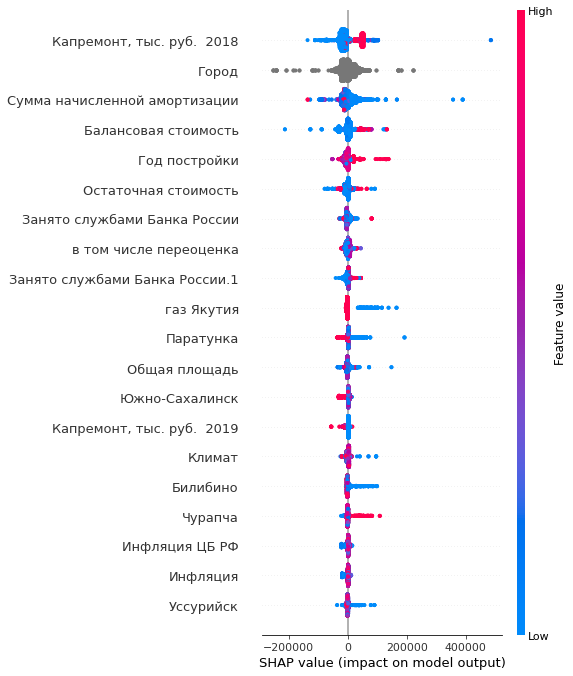

In [293]:
y = df_payment_el['payment']
X = df_payment_el.drop(columns=['payment',  'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл',])
X = X.fillna(0)

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CatBoost
model = CatBoostRegressor(verbose=100, random_state=42, cat_features=cat_features)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозы и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Среднеквадратическая ошибка: {mse}')

y_pred = model.predict(X_test)
diagnostics(y_test, y_pred)

import pickle

# Предположим, model - это ваша обученная модель
# Сохранение модели в файл
with open('model_el.pkl', 'wb') as file:
    pickle.dump(model, file)

tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)


In [ ]:
# Создание нового DataFrame на основе df_payment_el
new_df = df_payment_el.copy()

# Определение числовых и нечисловых столбцов
numeric_cols = new_df.select_dtypes(include=[np.number]).columns
non_numeric_cols = new_df.select_dtypes(exclude=[np.number]).columns

# Заполнение числовых столбцов средними значениями
for col in numeric_cols:
    new_df[col] = new_df[col].mean()

# Заполнение нечисловых столбцов наиболее часто встречающимися значениями
for col in non_numeric_cols:
    new_df[col] = new_df[col].mode()[0]

# Оставляем только первые 36 строк
new_df = new_df.iloc[:36]
new_df = new_df.drop(columns=['payment', 'Unnamed: 0.1', 'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл','Unnamed: 0.2'])

new_df.head()  # Показ первых строк нового DataFrame для проверки

dates = pd.date_range(start='2022-01-01', end='2024-12-01', freq='MS')


# Убедитесь, что в pred_df достаточно строк для заполнения датами
if len(new_df) <= len(dates):
    # Присваивание дат в 'Дата проведения'
    new_df['Дата проведения'] = dates[:len(new_df)]

    # Обновление 'month' и 'year' на основе 'Дата проведения'
    new_df['month'] = new_df['Дата проведения'].dt.month
    new_df['year'] = new_df['Дата проведения'].dt.year
else:
    print("Недостаточно дат для заполнения всех строк в pred_df")

with open('dataframe.pkl', 'wb') as file:
    pickle.dump(new_df, file)



Learning rate set to 0.049502
0:	learn: 295272.6031268	total: 58.4ms	remaining: 58.4s
100:	learn: 235240.4665357	total: 3.6s	remaining: 32s
200:	learn: 226285.0258601	total: 6.77s	remaining: 26.9s
300:	learn: 220556.4561651	total: 9.9s	remaining: 23s
400:	learn: 216711.2214020	total: 13s	remaining: 19.5s
500:	learn: 213437.2900951	total: 16.2s	remaining: 16.1s
600:	learn: 210884.4808657	total: 19.3s	remaining: 12.8s
700:	learn: 208539.0549796	total: 22.4s	remaining: 9.54s
800:	learn: 206797.0930882	total: 25.5s	remaining: 6.32s
900:	learn: 204874.3555569	total: 28.5s	remaining: 3.13s
999:	learn: 202681.0208534	total: 31.5s	remaining: 0us
Среднеквадратическая ошибка: 69552774573.93541


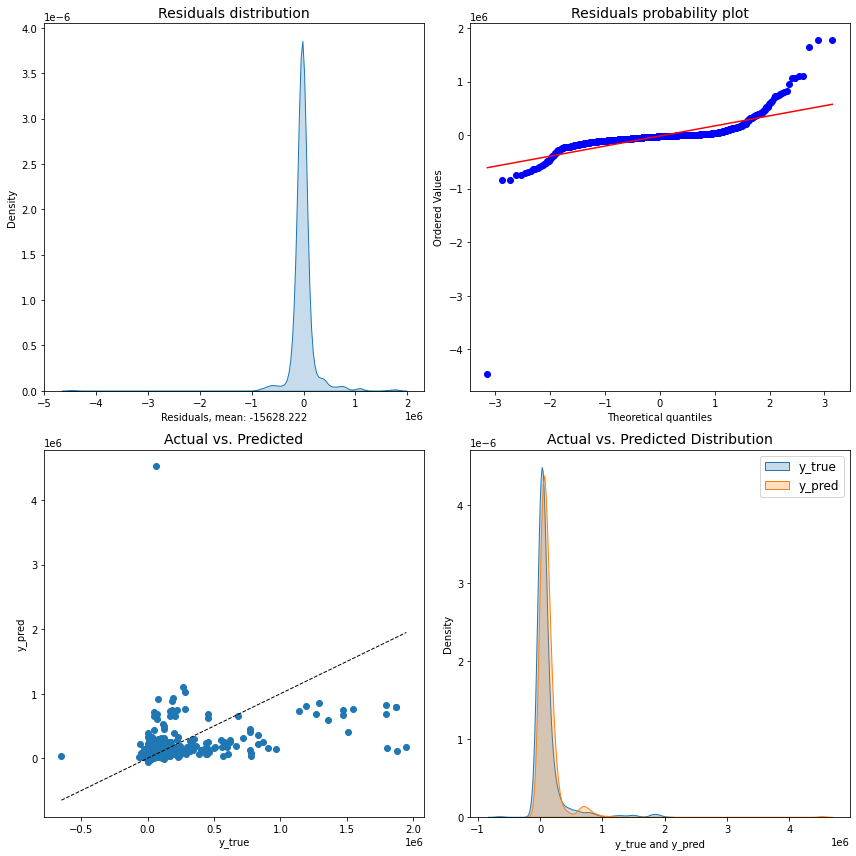

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


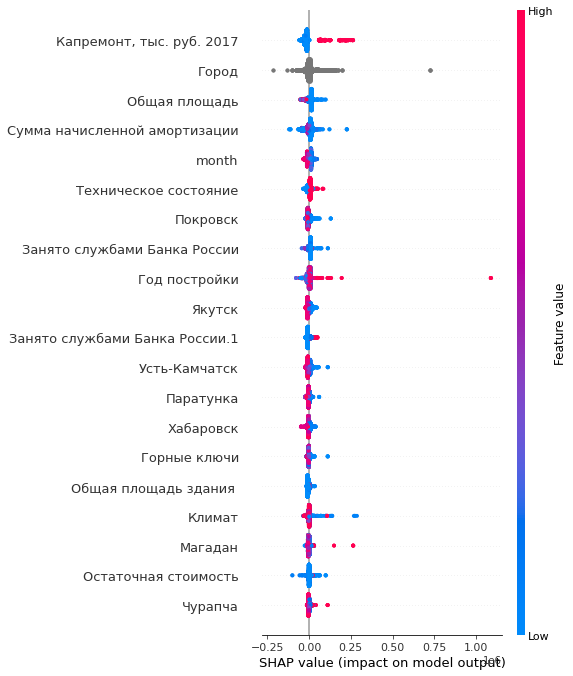

In [295]:
y = df_payment_teplo['payment']
X = df_payment_teplo.drop(columns=['payment',  'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл',])
X = X.fillna(0)

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CatBoost
model = CatBoostRegressor(verbose=100, random_state=42, cat_features=cat_features)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозы и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Среднеквадратическая ошибка: {mse}')

y_pred = model.predict(X_test)
diagnostics(y_test, y_pred)

import pickle

# Предположим, model - это ваша обученная модель
# Сохранение модели в файл
with open('model_teplo.pkl', 'wb') as file:
    pickle.dump(model, file)

tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Learning rate set to 0.02611
0:	learn: 62229.4851673	total: 45.3ms	remaining: 45.2s
100:	learn: 18251.0598658	total: 3.81s	remaining: 33.9s
200:	learn: 10971.8635970	total: 6.64s	remaining: 26.4s
300:	learn: 9344.8881171	total: 9.62s	remaining: 22.3s
400:	learn: 8677.0094349	total: 12.7s	remaining: 19s
500:	learn: 7935.8156338	total: 15.8s	remaining: 15.7s
600:	learn: 6834.0522414	total: 18.8s	remaining: 12.5s
700:	learn: 5877.4719634	total: 22.1s	remaining: 9.4s
800:	learn: 5288.1816008	total: 25s	remaining: 6.22s
900:	learn: 4840.1248526	total: 28.3s	remaining: 3.1s
999:	learn: 4651.5667449	total: 32s	remaining: 0us
Среднеквадратическая ошибка: 31985407783.684162


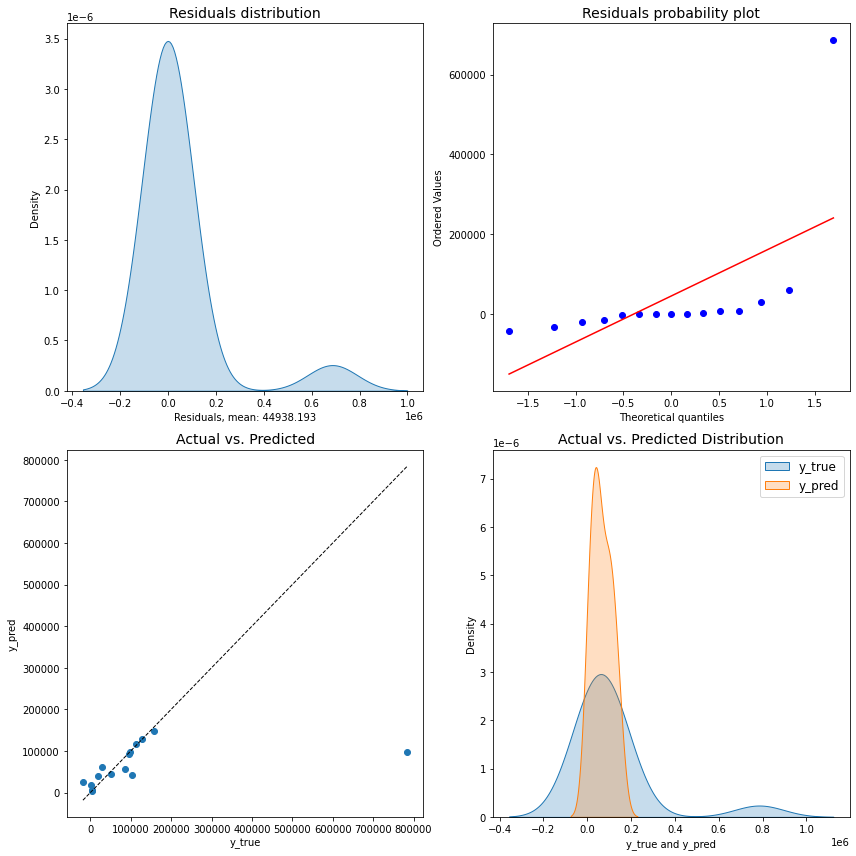

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


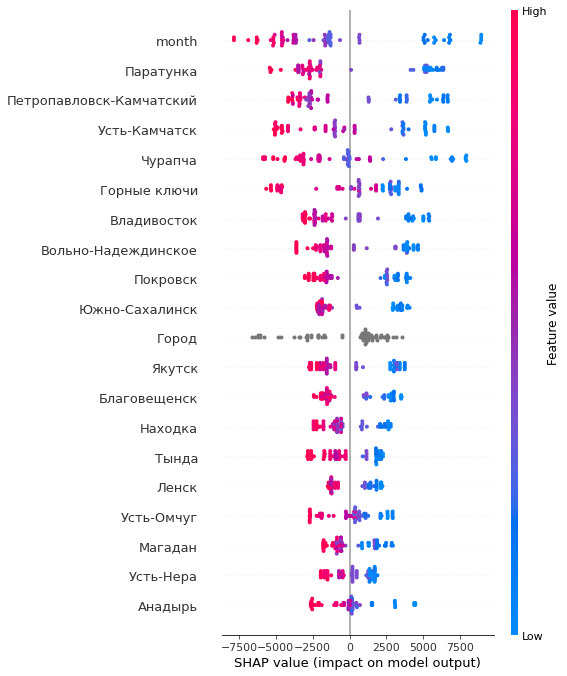

In [297]:
y = df_payment_gaz['payment']
X = df_payment_gaz.drop(columns=['payment',  'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл',])
X = X.fillna(0)

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CatBoost
model = CatBoostRegressor(verbose=100, random_state=42, cat_features=cat_features)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозы и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Среднеквадратическая ошибка: {mse}')

y_pred = model.predict(X_test)
diagnostics(y_test, y_pred)

import pickle

# Предположим, model - это ваша обученная модель
# Сохранение модели в файл
with open('model_gaz.pkl', 'wb') as file:
    pickle.dump(model, file)

tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Learning rate set to 0.056124
0:	learn: 11831.6239968	total: 46.6ms	remaining: 46.6s
100:	learn: 9304.4516843	total: 4.13s	remaining: 36.8s
200:	learn: 9021.1277358	total: 9.74s	remaining: 38.7s
300:	learn: 8809.6617234	total: 13.2s	remaining: 30.6s
400:	learn: 8672.3828397	total: 16.6s	remaining: 24.7s
500:	learn: 8556.9594803	total: 20.1s	remaining: 20s
600:	learn: 8436.6102473	total: 23.9s	remaining: 15.8s
700:	learn: 8345.8438747	total: 28.2s	remaining: 12s
800:	learn: 8259.8846389	total: 33s	remaining: 8.19s
900:	learn: 8181.1875233	total: 37.2s	remaining: 4.09s
999:	learn: 8103.2217220	total: 41.8s	remaining: 0us
Среднеквадратическая ошибка: 292478996.6976097


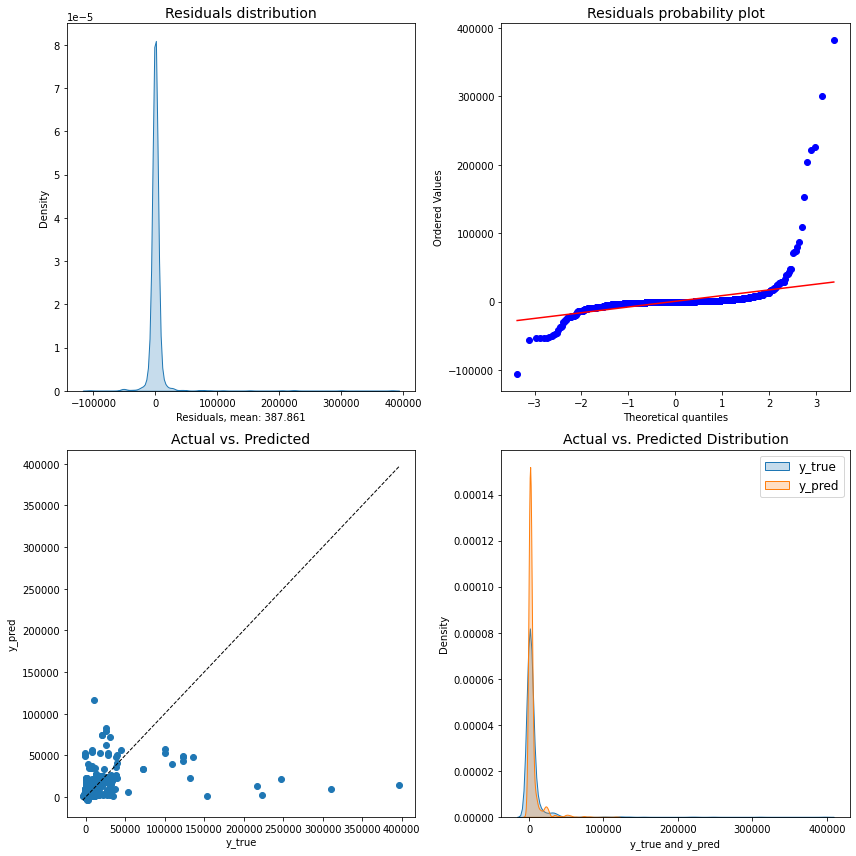

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


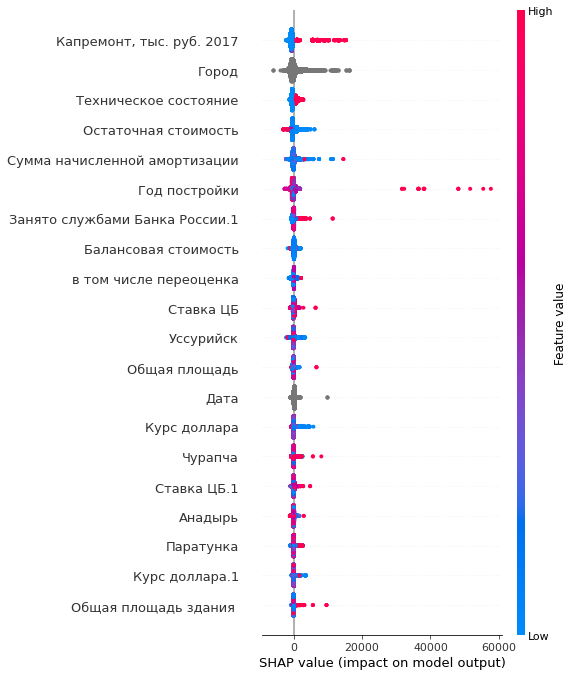

In [300]:
y = df_payment_voda['payment']
X = df_payment_voda.drop(columns=['payment',  'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл',])
X = X.fillna(0)

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели CatBoost
model = CatBoostRegressor(verbose=100, random_state=42, cat_features=cat_features)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозы и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Среднеквадратическая ошибка: {mse}')

y_pred = model.predict(X_test)
diagnostics(y_test, y_pred)

import pickle

# Предположим, model - это ваша обученная модель
# Сохранение модели в файл
with open('model_voda.pkl', 'wb') as file:
    pickle.dump(model, file)

tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [324]:
# Создание нового DataFrame на основе df_payment_el
new_df = df_payment_el.copy()

# Определение числовых и нечисловых столбцов
numeric_cols = new_df.select_dtypes(include=[np.number]).columns
non_numeric_cols = new_df.select_dtypes(exclude=[np.number]).columns

# Заполнение числовых столбцов средними значениями
for col in numeric_cols:
    new_df[col] = new_df[col].mean()

# Заполнение нечисловых столбцов наиболее часто встречающимися значениями
for col in non_numeric_cols:
    new_df[col] = new_df[col].mode()[0]

# Оставляем только первые 36 строк
new_df = new_df.iloc[:36]
new_df = new_df.drop(columns=['payment', 'Unnamed: 0', 'matched_id', 'id','Подразделение БР','Наименование вида расходов', 'Направление расходов','Название','Дата проведения', 
                                'Дата принятия на баланс','Описание ремонта', 'вода Камчатский край', 'вода Сахалинская обл',])

new_df.head()  # Показ первых строк нового DataFrame для проверки

dates = pd.date_range(start='2022-01-01', end='2024-12-01', freq='MS')


# Убедитесь, что в pred_df достаточно строк для заполнения датами
if len(new_df) <= len(dates):
    # Присваивание дат в 'Дата проведения'
    new_df['Дата проведения'] = dates[:len(new_df)]

    # Обновление 'month' и 'year' на основе 'Дата проведения'
    new_df['month'] = new_df['Дата проведения'].dt.month
    new_df['year'] = new_df['Дата проведения'].dt.year
else:
    print("Недостаточно дат для заполнения всех строк в pred_df")

# Загрузите DataFrame из файла prognoz.xlsx
prognoz_df = pd.read_excel('prognoz.xlsx')

# Проверьте совпадение названий столбцов между new_df и prognoz_df
common_columns = set(new_df.columns).intersection(prognoz_df.columns)

# Замените значения столбцов в new_df на значения из prognoz_df
for column in common_columns:
    new_df[column] = prognoz_df[column]

# Теперь в new_df будут заменены значения столбцов из prognoz_df, если названия столбцов совпадают.

with open('dataframe.pkl', 'wb') as file:
    pickle.dump(new_df, file)


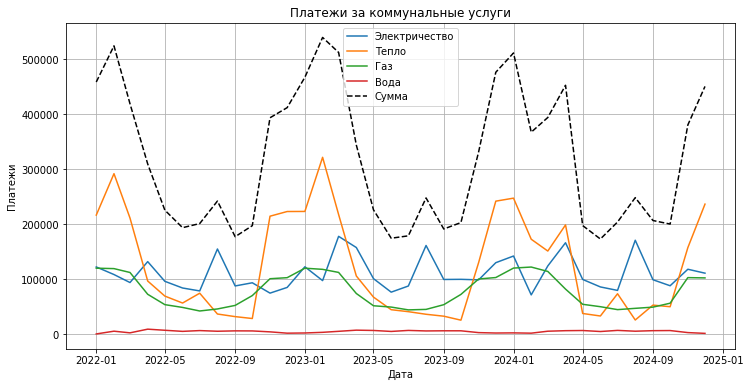

In [333]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

city = "Находка"
area = 200
temperature = -5
inflation = 0
taxes = 0
expenses = 1000

with open('dataframe.pkl', 'rb') as file:
    pred_df = pickle.load(file)

pred_df['Город'] = city
    
pred_df['Общая площадь'] = area
pred_df['Общая площадь здания '] = area
pred_df['Занято службами Банка России'] = area/1.28
pred_df['Сдается Банком России в аренду'] = area/151

pred_df['Капремонт, тыс. руб. 2017'] -= expenses/7
pred_df['Капремонт, тыс. руб.  2018'] -=  expenses/7
pred_df['Капремонт, тыс. руб.  2019'] -=  expenses/7
pred_df['Капремонт, тыс. руб.  2020'] -=  expenses/7
pred_df['Капремонт, тыс. руб.  2021'] -=  expenses/7
pred_df['Капремонт, тыс. руб.  2022'] -=  expenses/7
pred_df['Капремонт, тыс. руб.  2023'] -=  expenses/7

pred_df['Налог'] = taxes

pred_df['Инфляция ЦБ РФ'] = inflation

pred_df['Температура'] += temperature
pred_df['Анадырь'] += temperature
pred_df['Билибино'] += temperature
pred_df['Биробиджан'] += temperature
pred_df['Благовещенск'] += temperature
pred_df['Владивосток'] += temperature
pred_df['Вольно-Надеждинское'] += temperature
pred_df['Горные ключи'] += temperature
pred_df['Ключи'] += temperature
pred_df['Комсомольск-на-Амуре'] += temperature
pred_df['Ленск'] += temperature
pred_df['Магадан'] += temperature
pred_df['Находка'] += temperature
pred_df['Паратунка'] += temperature
pred_df['Петропавловск-Камчатский'] += temperature
pred_df['Покровск'] += temperature
pred_df['Тында'] += temperature
pred_df['Уссурийск'] += temperature
pred_df['Усть-Камчатск'] += temperature
pred_df['Усть-Нера'] += temperature
pred_df['Усть-Омчуг'] += temperature
pred_df['Хабаровск'] += temperature
pred_df['Чурапча'] += temperature
pred_df['Южно-Сахалинск'] += temperature
pred_df['Якутск'] += temperature

with open('model_el.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred_el = loaded_model.predict(pred_df)

result_el = {
    '2022':y_pred_el[0:11].sum(),
    '2023':y_pred_el[12:23].sum(),
    '2024':y_pred_el[24:35].sum()
}



with open('model_teplo.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred_teplo = loaded_model.predict(pred_df)

result_teplo = {
    '2022':y_pred_teplo[0:11].sum(),
    '2023':y_pred_teplo[12:23].sum(),
    '2024':y_pred_teplo[24:35].sum()
}

with open('model_gaz.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred_gaz = loaded_model.predict(pred_df)

result_gaz = {
    '2022':y_pred_gaz[0:11].sum(),
    '2023':y_pred_gaz[12:23].sum(),
    '2024':y_pred_gaz[24:35].sum()
}

with open('model_voda.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred_voda = loaded_model.predict(pred_df)

result_voda = {
    '2022':y_pred_voda[0:11].sum(),
    '2023':y_pred_voda[12:23].sum(),
    '2024':y_pred_voda[24:35].sum()
}

dates = pd.date_range(start='2022-01-01', end='2024-12-01', freq='MS')

# Суммирование платежей для всех услуг за каждый месяц
total_payments = y_pred_el + y_pred_teplo + y_pred_gaz + y_pred_voda

# Проверка, что количество дат совпадает с размером массивов
if len(dates) == len(y_pred_el) == len(y_pred_teplo) == len(y_pred_gaz) == len(y_pred_voda):
    # Построение графиков
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_pred_el, label='Электричество')
    plt.plot(dates, y_pred_teplo, label='Тепло')
    plt.plot(dates, y_pred_gaz, label='Газ')
    plt.plot(dates, y_pred_voda, label='Вода')
    plt.plot(dates, total_payments, label='Сумма', color='black', linestyle='--')

    # Настройка графика
    plt.title('Платежи за коммунальные услуги')
    plt.xlabel('Дата')
    plt.ylabel('Платежи')
    plt.legend()
    plt.grid(True)
    plt.savefig('utility_payments.png')
else:
    print("Количество дат и элементов в массивах не совпадает.")
